# Variational Autoencoder (VAE)

## Import libraries

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Set Hyperparameters

In [ ]:
# Seed
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

# Hyper-parameters for MLP VAE Model
# Data
img_size = (1, 28, 28)
x_dim = 784

# Model
hidden_dim = 64
latent_dim = 2

# Optimizer
learning_rate = 1e-3

# Training
epochs = 50
batch_size = 128

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Prepare DataLoader


In [ ]:
# Image transform
img_transform = transforms.Compose([transforms.ToTensor(),])

# Train dataset & dataloader
train_dataset = datasets.MNIST(root='~/data', download=True, train=True, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test dataset & dataloader
test_dataset = datasets.MNIST(root='~/data', download=True, train=False, transform=img_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Define VAE Models

### Define MLPEncoder and Decoder

In [ ]:
class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(MLPEncoder, self).__init__()

        # Activation function
        self.act = nn.LeakyReLU(negative_slope=0.1)

        # Layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out_mean = nn.Linear(hidden_dim, latent_dim)
        self.out_log_std = nn.Linear(hidden_dim, latent_dim) # log for non-negativity

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        mean = self.out_mean(x)
        log_std = self.out_log_std(x)
        return mean, log_std


class MLPDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(MLPDecoder, self).__init__()

        # Activation function
        self.act = nn.LeakyReLU(negative_slope=0.1)

        # Layers
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = F.sigmoid(self.out(x))
        return out


### Define VAE Model

In [ ]:
class MLPVAEModel(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(MLPVAEModel, self).__init__()
        self.encoder = MLPEncoder(input_dim=x_dim,
                                  hidden_dim=hidden_dim,
                                  latent_dim=latent_dim)
        self.decoder = MLPDecoder(latent_dim=latent_dim,
                                  hidden_dim=hidden_dim,
                                  output_dim=x_dim)

    def sample(self, mean, log_std):
        if self.training:
            eps = torch.randn_like(log_std)
            z = mean + eps * torch.exp(log_std)
        else:
            z = mean
        return z

    def forward(self, x):
        mean, log_std = self.encoder(x)
        z = self.sample(mean, log_std)
        out = self.decoder(z)
        return out, mean, log_std

    def encode(self, x):
        mean, log_std = self.encoder(x)
        return mean, log_std

    def generate(self, z):
        return self.decoder(z)

### Define vae_loss


* Hint: KL Divergence between two Gaussian Distributions $(p,q)$ \\
$p(x) = N(\mu_1, \sigma_1), q(x) = N(\mu_2, \sigma_2)$ \\
$KL(p,q) = \log\frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2} - \frac{1}{2}$ \\
[Ref](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)

In [ ]:
def vae_loss(x, output_x, mean, log_std):
    batch_size = x.size(0)
    recon_loss = F.binary_cross_entropy(output_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + 2 * log_std - mean ** 2 - torch.exp(2 * log_std))
    return recon_loss + kl_loss

## Train


### Model & Optimzer

In [ ]:
# Model
model = MLPVAEModel(x_dim, hidden_dim, latent_dim)
model.to(device)

# Optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

### Train epochs

In [ ]:
model.train()
print('Start')
avg_train_loss = []
for epoch in range(epochs):
    train_loss = []
    for x, _ in train_loader:
        # to device
        x = x.to(device)
        x = x.view(-1, x_dim)  # (batch_size, 784)

        # zero_grad
        optimizer.zero_grad()

        # compute the loss
        output_x, mean, log_std = model(x)
        loss = vae_loss(x, output_x, mean, log_std)

        # train_loss logging
        train_loss.append(loss.item())

        # Adam updates
        loss.backward()
        optimizer.step()
    avg_train_loss.append(np.mean(train_loss))
    print("Epoch:{:2}, AverageLoss:{:5.4g}".format(epoch + 1, avg_train_loss[-1]))
print('Finish')

Start
Epoch: 1, AverageLoss:217.7
Epoch: 2, AverageLoss:178.1
Epoch: 3, AverageLoss:169.6
Epoch: 4, AverageLoss:166.3
Epoch: 5, AverageLoss:164.2
Epoch: 6, AverageLoss:162.2
Epoch: 7, AverageLoss:  160
Epoch: 8, AverageLoss:  158
Epoch: 9, AverageLoss:156.6
Epoch:10, AverageLoss:155.5
Epoch:11, AverageLoss:154.5
Epoch:12, AverageLoss:153.8
Epoch:13, AverageLoss:  153
Epoch:14, AverageLoss:152.3
Epoch:15, AverageLoss:151.7
Epoch:16, AverageLoss:151.2
Epoch:17, AverageLoss:150.7
Epoch:18, AverageLoss:150.3
Epoch:19, AverageLoss:149.8
Epoch:20, AverageLoss:149.5
Epoch:21, AverageLoss:149.1
Epoch:22, AverageLoss:148.8
Epoch:23, AverageLoss:148.6
Epoch:24, AverageLoss:148.1
Epoch:25, AverageLoss:147.8
Epoch:26, AverageLoss:147.7
Epoch:27, AverageLoss:147.4
Epoch:28, AverageLoss:147.2
Epoch:29, AverageLoss:146.9
Epoch:30, AverageLoss:146.7
Finish


### Plot Training loss curve

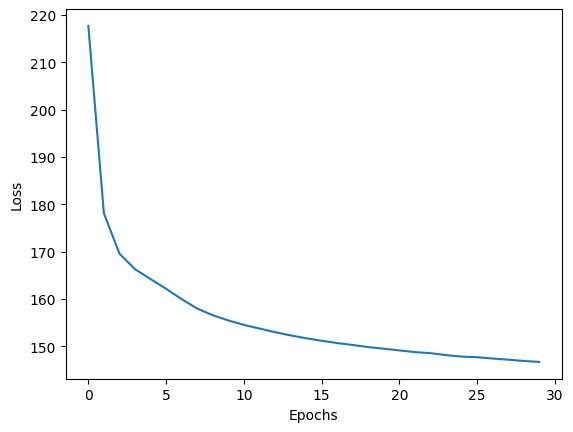

In [ ]:
fig = plt.figure()
plt.plot(avg_train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluation

### Compute Test loss


In [ ]:
model.eval()
test_loss = []
for x, _ in test_loader:
    # to device
    x = x.to(device)
    x = x.view(-1, x_dim)

    # compute loss
    with torch.no_grad():
        output_x, mean, log_std = model(x)
        loss = vae_loss(x, output_x, mean, log_std)
        test_loss.append(loss.item())
print('Test loss:{:5.4g}'.format(np.mean(test_loss)))

Test loss:  147


### Comparison between the original and reconstructed images

Original images


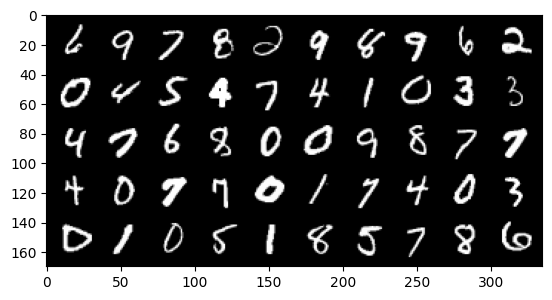

Reconstructed images


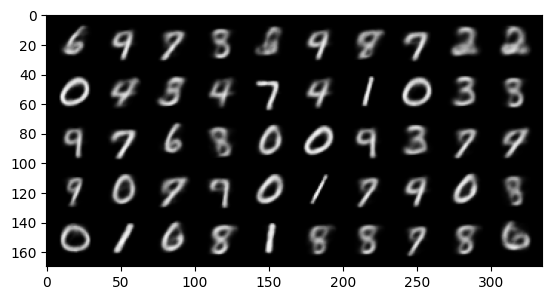

In [ ]:
# visualize images x
def show_image(x):
    x = x.clamp(0, 1)
    plt.imshow(np.transpose(x.numpy(), (1, 2, 0)))

# visualize an reconstructed image from x
def show_output_x(x):
    model.eval()
    with torch.no_grad():
        # to device
        x = x.to(device)
        x = x.view(-1, x_dim)

        # reconstruct images
        output_x, _, _ = model(x)
        output_x = output_x.cpu().view(-1, *img_size).clamp(0, 1)

        # visualize
        img_grid = make_grid(output_x[:50], 10, 5).numpy()
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.show()

# Sample dataset
x, _ = next(iter(test_loader))

# Visualize original images
print('Original images')
show_image(make_grid(x[:50], 10, 5))
plt.show()

# Visualize reconstructed images
print('Reconstructed images')
show_output_x(x)

### VAE as an image generator

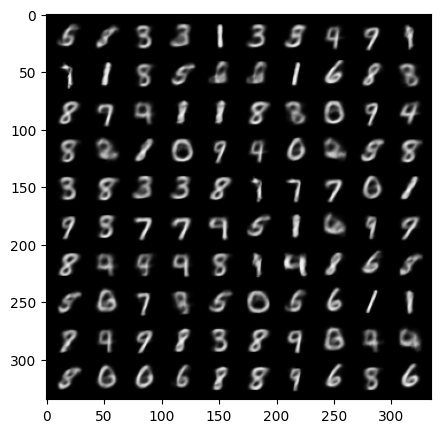

In [ ]:
model.eval()
with torch.no_grad():
    # Sample 100 latent vectors from the normal distribution
    z = torch.randn(100, latent_dim, device=device)

    # Generate images from the latent vectors
    gen_x = model.generate(z).cpu().view(-1, *img_size).clamp(0, 1)

# Visualize
fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(gen_x.data,10,5))
plt.show()

### Show 2D latent space

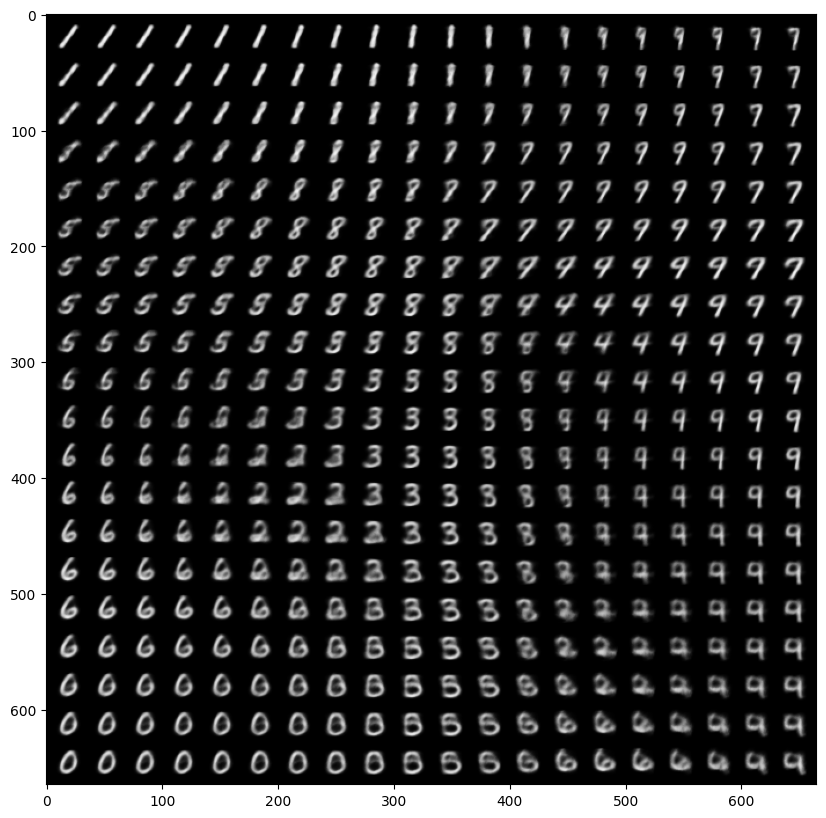

In [ ]:
model.eval()
with torch.no_grad():
    # Create latent vectors spread on a 2d space
    temp = torch.linspace(-1.5, 1.5, steps=20).expand((20, 20))
    latents = torch.stack([temp, temp.transpose(0,1)], dim=-1)
    latents = latents.view(-1, 2).to(device)

    # Generate images from the latent vectors
    output_x = model.generate(latents)
    output_x = output_x.cpu().view(-1, *img_size)

# Visualize
fig, ax = plt.subplots(figsize=(10, 10))
show_image(make_grid(output_x.data.cpu()[:400],20,5))
plt.show()